<a href="https://colab.research.google.com/github/Pysrdafoice/DIO_cats_and_dogsML/blob/main/ProjetoML_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

In [ ]:
# Descompactando o arquivo zipado
#!unzip -q "kagglecatsanddogs_5340.zip" -d "./"

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
#validação dos dados

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


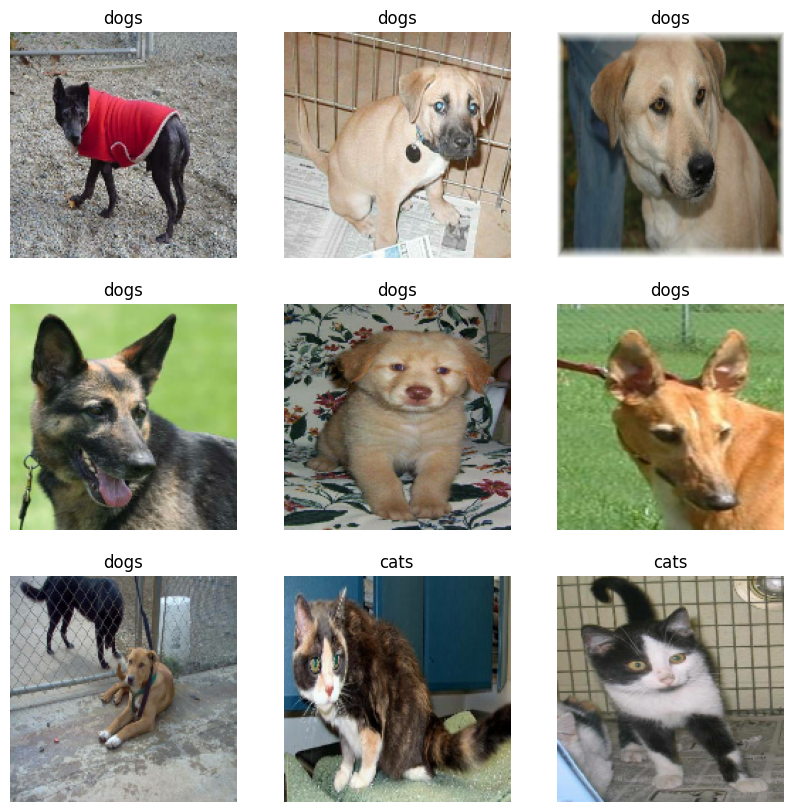

In [ ]:
#visualizando as amostras

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1), plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#separação dos dados para criação do conjunto de testes

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Número de lotes de validação: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Número de lotes de teste: %d' % tf.data.experimental.cardinality(test_dataset))

Número de lotes de validação: 26
Número de lotes de teste: 6


In [ ]:
#Agora configurar o conjunto de dados para desempenho

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch

2


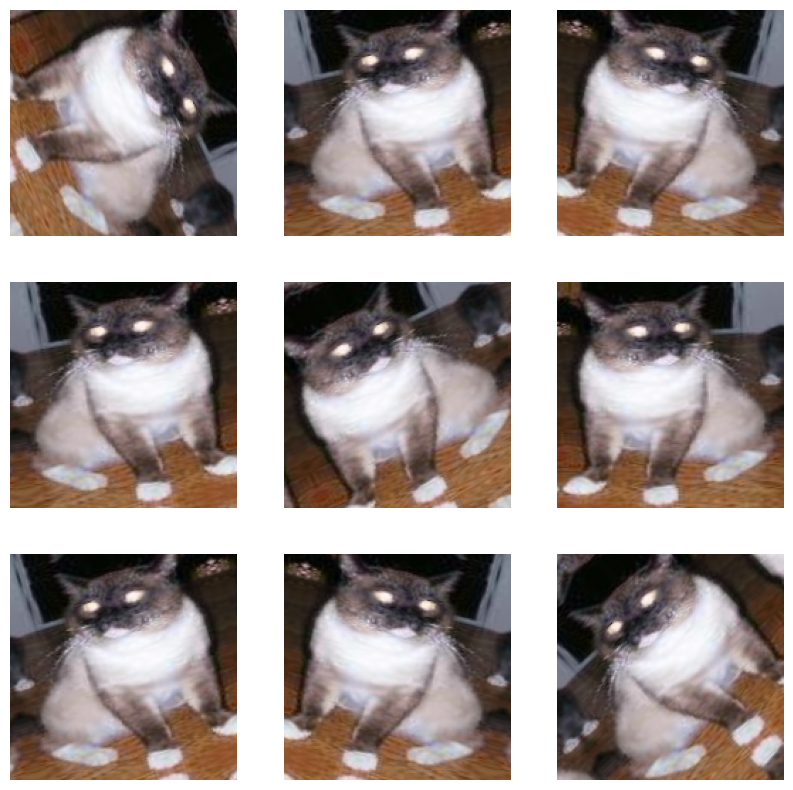

In [ ]:
#Fazer girar as imagens para aumentar a quantidade para evitar overfitting

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

print(len(data_augmentation.layers))

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')



In [ ]:
#mudar os pixels da imagem de (0, 255) para (1, -1)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#ou

#from tensorflow.keras.layers import Rescaling

# Criando a camada de rescaling
#rescaling_layer = Rescaling(scale=1./127.5, offset=-1)


In [ ]:
#Adicionei a base do modelo de pré-treinamneta do modelo MobileNetV2
#Converto as imagens(160 X 160) para (5x5x1280)

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))

feature_batch = base_model(image_batch)
print(feature_batch.shape)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(32, 5, 5, 1280)


In [ ]:
#congelando o modelo de treinamento para não destui-lo

base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#adicionando cabeçalho

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers


(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
print(prediction_batch)


(32, 1)
tf.Tensor(
[[-0.5566423 ]
 [-0.9852707 ]
 [-0.56215274]
 [-0.87170374]
 [-0.82007813]
 [-2.3429728 ]
 [ 0.5301046 ]
 [-1.0527701 ]
 [-0.5955044 ]
 [ 0.44421172]
 [ 0.8272129 ]
 [ 1.3779068 ]
 [-0.67784584]
 [-0.74381214]
 [-0.17521608]
 [-0.73320186]
 [-0.15080321]
 [-0.6607616 ]
 [-0.9487424 ]
 [-0.05880153]
 [-0.67347085]
 [-0.82484317]
 [-0.76016164]
 [ 0.03162599]
 [-0.7869804 ]
 [-1.1069753 ]
 [-0.56155753]
 [-0.9558578 ]
 [ 0.04582202]
 [ 0.5199343 ]
 [ 0.6068733 ]
 [ 0.0521996 ]], shape=(32, 1), dtype=float32)


In [ ]:
#modelo de encadeamento e compilação

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
len(model.trainable_variables)


2

In [ ]:
#treimento do modelo

initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 618ms/step - accuracy: 0.5184 - loss: 0.7918
initial loss: 0.79
initial accuracy: 0.50
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 911ms/step - accuracy: 0.5312 - loss: 0.7774 - val_accuracy: 0.7104 - val_loss: 0.5146
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 917ms/step - accuracy: 0.6568 - loss: 0.5757 - val_accuracy: 0.8218 - val_loss: 0.3809
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 928ms/step - accuracy: 0.7645 - loss: 0.4357 - val_accuracy: 0.8849 - val_loss: 0.2904
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8125 - loss: 0.3893 - val_accuracy: 0.9233 - val_loss: 0.2423
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8434 - loss: 0.3241 - val_accuracy: 0.9332 - val_loss: 0.2026
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 976ms/step - accuracy: 0.8672 - loss: 0.3037 - val_accuracy: 0.9394 - val_loss: 0.1818
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 926ms/step - accuracy: 0.8763 - loss: 0.2762 - val_accuracy: 0.9443 - va

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

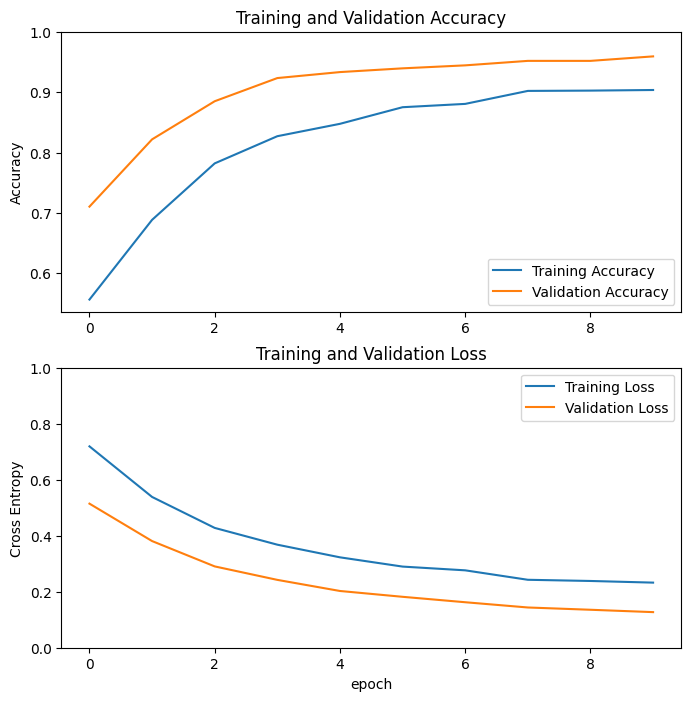

In [ ]:
#plotar o resultar e ver a cruva de aprendizado
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Descongelar os modelos convolucional para treina-los(ajuste-fino)

base_model.trainable = True

# Ver quantas camadas existem no modelo base
print("Number of layers in the base model: ", len(base_model.layers))

# Ajuste fino a partir desta camada em diante
fine_tune_at = 100

# Congele todas as camadas antes da camada `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#Compilar modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()
len(model.trainable_variables)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

56

In [ ]:
#trinar novamente

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)



Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8182 - loss: 0.4526 - val_accuracy: 0.9777 - val_loss: 0.0900
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8865 - loss: 0.3010 - val_accuracy: 0.9790 - val_loss: 0.0760
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9034 - loss: 0.2452 - val_accuracy: 0.9790 - val_loss: 0.0644
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9174 - loss: 0.1863 - val_accuracy: 0.9814 - val_loss: 0.0555
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9332 - loss: 0.1700 - val_accuracy: 0.9839 - val_loss: 0.0533
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9258 - loss: 0.1614 - val_accuracy: 0.9864 - val_loss: 0.0461
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9255 - loss: 0.1765 - val_accuracy: 0.9876 - val_loss: 0.0456
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9385 - loss: 0.1378 - val_accuracy: 0.9

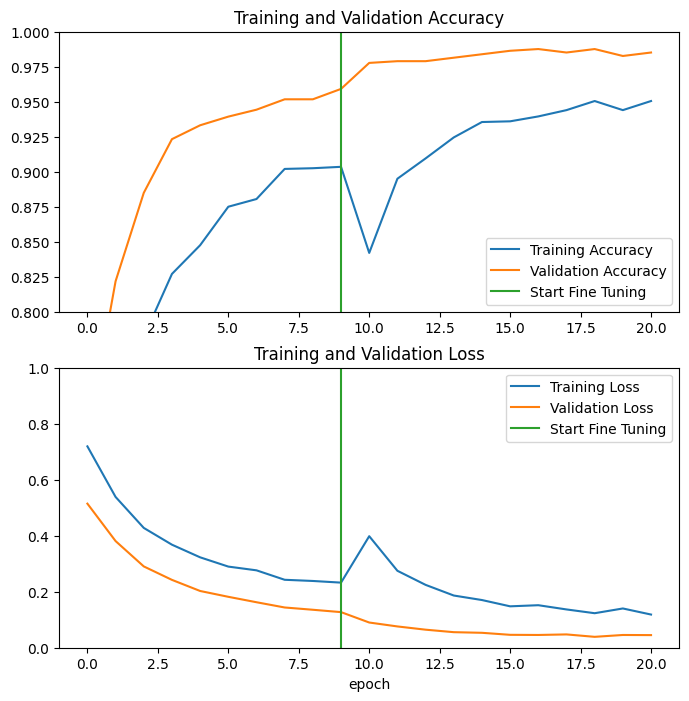

In [ ]:
#Visualizar se tem overfitting

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
#validando a precisão
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 558ms/step - accuracy: 0.9850 - loss: 0.0400
Test accuracy : 0.9839109182357788


In [ ]:
#Modelo pronto, usando pra identificar se é cachorro ou gato

image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)


plt.figure(figsize=(10, 10))


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Resultado:  [1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0]
Resultado real:  [1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0]


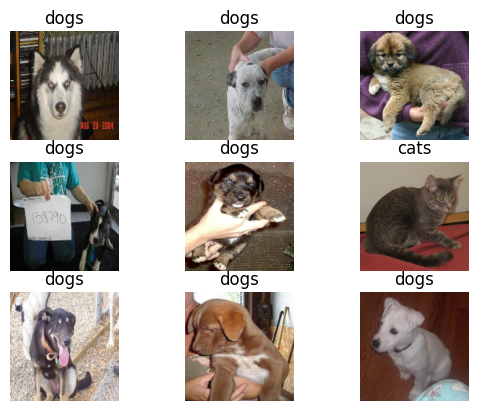

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

print('Resultado: ', predictions.numpy())
print('Resultado real: ', label_batch)